In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tqdm
import os
import pickle
import tqdm

import xgboost
from sklearn.model_selection import train_test_split

import slice_finding as sf
from importlib import reload
reload(sf);

In [ ]:
df = pd.read_csv("example_data/adult.csv")
df.head()
print (len(df))

In [ ]:
def _assign_bin_values(col_data, bin_spec):
    lower = bin_spec.get("min", np.quantile(col_data, 0.25))
    upper = bin_spec.get("max", np.quantile(col_data, 0.75))
    assert lower < upper, (lower, upper)
    return np.digitize(col_data, [lower, upper])

def extreme_value_binning(col_name, col_data, gender_data):
    if col_name not in NORMAL_RANGES:
        return np.digitize(col_data, np.quantile(col_data, [0.25, 0.75]))
    norm_range = NORMAL_RANGES[col_name]
    if "female" in norm_range:
        return np.where(gender_data, 
                        _assign_bin_values(col_data, norm_range["female"]),
                        _assign_bin_values(col_data, norm_range["male"]))
    return _assign_bin_values(col_data, norm_range)

def discretize_data(df, spec):
    discrete_columns = {}
    for col, col_spec in spec.items():
        if callable(col_spec["method"]):
            discrete_columns[col] = col_spec["method"](df[col], col)
        elif col_spec["method"] == "keep":
            discrete_columns[col] = df[col].values
        elif col_spec["method"] == "bin":
            discrete_columns[col] = np.digitize(df[col], col_spec["bins"]) - 1
        elif col_spec["method"] == "unique":
            unique_vals = sorted(df[col].unique().tolist())
            discrete_columns[col] = df[col].apply(lambda v: unique_vals.index(v))
    return pd.DataFrame(discrete_columns, index=df.index)

discrete_df = discretize_data(df, {
    'age': { "method": "bin", "bins": [0, 25, 45, 65] }, 
    'workclass': { "method": "unique" }, 
    'education': { "method": "unique" }, 
    'marital-status': { "method": "unique" }, 
    'occupation': { "method": "unique" }, 
    'relationship': { "method": "unique" }, 
    'race': { "method": "unique" }, 
    'gender': { "method": "unique" },   
    'capital-gain': { "method": "bin", "bins": [0, 1] }, 
    'capital-loss': { "method": "bin", "bins": [0, 1] }, 
    'hours-per-week': { "method": "bin", "bins": [0, 39] }, 
    'native-country': { "method": lambda x, c: x != 'United-States' },
})

In [ ]:
df_prepped = df.drop(columns=['fnlwgt', 'educational-num'])

X = df_prepped.drop(columns=['income'])
y = df_prepped['income'] == '>50K'

X_continous  = X[['age', 'capital-gain', 'capital-loss', 'hours-per-week']]
print (X_continous.head())
X_categorical = X[['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race',
                   'gender', 'native-country']]
print (X_categorical.head())
X_encoded = pd.get_dummies(X_categorical)
print ("encoded:")
print ("")
print (X_encoded)

X = pd.concat([X_continous, X_encoded], axis=1)

In [ ]:
import os

if not os.path.exists("example_data/adult_model.json"):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

    model = xgboost.XGBClassifier()
    model.fit(X_train, y_train)

    print(model.score(X_test, y_test))

    model.save_model("example_data/adult_model.json")
else:
    model = xgboost.XGBClassifier()
    model.load_model("example_data/adult_model.json")

In [ ]:
outcome_bins = 10
model_preds = model.predict(X)
discrete_outcomes = model_preds == y # df["income"] == ">50K"
print(discrete_outcomes.mean())

# Set up score functions
score_functions = {
    "error_rate": sf.OutcomeRateScore(1 - discrete_outcomes.values),
    "group_size": sf.SliceSizeScore(0.5, spread=0.25),
}

# the slices must contain at least this fraction of the dataset.
# a higher value would mean that fewer slices are eligible, and
# also that sampling is more likely to work well
min_items = int(len(discrete_df) * 0.001)
# 0.05, 0.01, 0.005, 0.001

num_slices_to_return = 50

max_features = 3
min_items

## Run recursive implementation

In [ ]:
results = sf.find_slices(
    discrete_df.astype(int),
    score_functions,
    min_items=min_items, 
    n_slices=num_slices_to_return,
    algorithm='recursive',
    max_features=max_features,
)

In [ ]:
results

## Run sampling implementation

In [ ]:
def get_sampling_avg_recall_random(number_of_samples, number_of_iterations):
    results_sampling_unranked_random = []
    
    for i in tqdm.tqdm(range(number_of_iterations)):
        tmp_results_sampling_unranked_random = sf.find_slices(
            discrete_df.astype(int),
            score_functions,
            algorithm='sampling',
            source_mask=None,
            min_items=min_items,
            num_samples=number_of_samples,
            num_candidates=None,
            max_features=max_features,
            show_progress=False
        )
        tmp_results_sampling_random = tmp_results_sampling_unranked_random.rank({fn_name: 1.0 for fn_name in score_functions},
                                                          n_slices=num_slices_to_return, 
                                                          similarity_threshold=1.0)
        random_sampling_recall = len(set(tmp_results_sampling_random) & set(results)) / len(results)

        results_sampling_unranked_random.append(random_sampling_recall)
    
    print (results_sampling_unranked_random)
    results_sampling_unranked_random = np.array(results_sampling_unranked_random)
    
    return results_sampling_unranked_random;
#     return sum(results_sampling_unranked_random) / len(results_sampling_unranked_random)

def get_sampling_avg_recall_selective(number_of_samples, number_of_iterations):
    results_sampling_unranked_selective = []
    
    for i in tqdm.tqdm(range(number_of_iterations)):
        tmp_results_sampling_unranked = sf.find_slices(
            discrete_df.astype(int),
            score_functions,
            algorithm='sampling',
            source_mask= (discrete_outcomes == 0),
            min_items=min_items,
            num_samples=number_of_samples,
            num_candidates=None,
            max_features=max_features,
            show_progress=False
        )
        tmp_results_sampling_selective = tmp_results_sampling_unranked.rank({fn_name: 1.0 for fn_name in score_functions},
                                                          n_slices=num_slices_to_return, 
                                                          similarity_threshold=1.0)
        
        selective_sampling_recall = len(set(tmp_results_sampling_selective) & set(results)) / len(results)

        results_sampling_unranked_selective.append(selective_sampling_recall)
    
    print (results_sampling_unranked_selective)
    results_sampling_unranked_selective = np.array(results_sampling_unranked_selective)
    return results_sampling_unranked_selective
#     return sum(results_sampling_unranked_selective) / len(results_sampling_unranked_selective)


In [ ]:
def get_recall_random_samplings (sample_count_list, number_of_iterations):
    recall_random_samplings = {}
    for number_of_samples in sample_count_list:
        recall_random_sampling = get_sampling_avg_recall_random(number_of_samples, number_of_iterations)
        recall_random_samplings[number_of_samples] = recall_random_sampling
    return recall_random_samplings
    
def get_recall_selective_samplings (sample_count_list, number_of_iterations):
    recall_random_samplings = {}
    for number_of_samples in sample_count_list:
        recall_random_sampling = get_sampling_avg_recall_selective(number_of_samples, number_of_iterations)
        recall_random_samplings[number_of_samples] = recall_random_sampling
    return recall_random_samplings

In [ ]:
number_of_iterations = 50

sample_count_list = [1, 5, 10, 50, 100, 250, 500]

recall_random_samplings = get_recall_random_samplings(sample_count_list, number_of_iterations)
recall_selective_samplings = get_recall_selective_samplings(sample_count_list, number_of_iterations)

In [ ]:
print (np.sum(discrete_outcomes == 0))

print (recall_random_samplings)
print (recall_selective_samplings)

In [50]:
# # Recall
# print ("Random Sampling Recall:", recall_random_sampling)
# print ("Selective Sampling Recall:", recall_selective_sampling)

In [69]:
with open(os.path.join("example_data", f"adult_experiment_min_items_{min_items}.pkl"), "wb") as file:
    pickle.dump((recall_random_samplings, recall_selective_samplings), file)

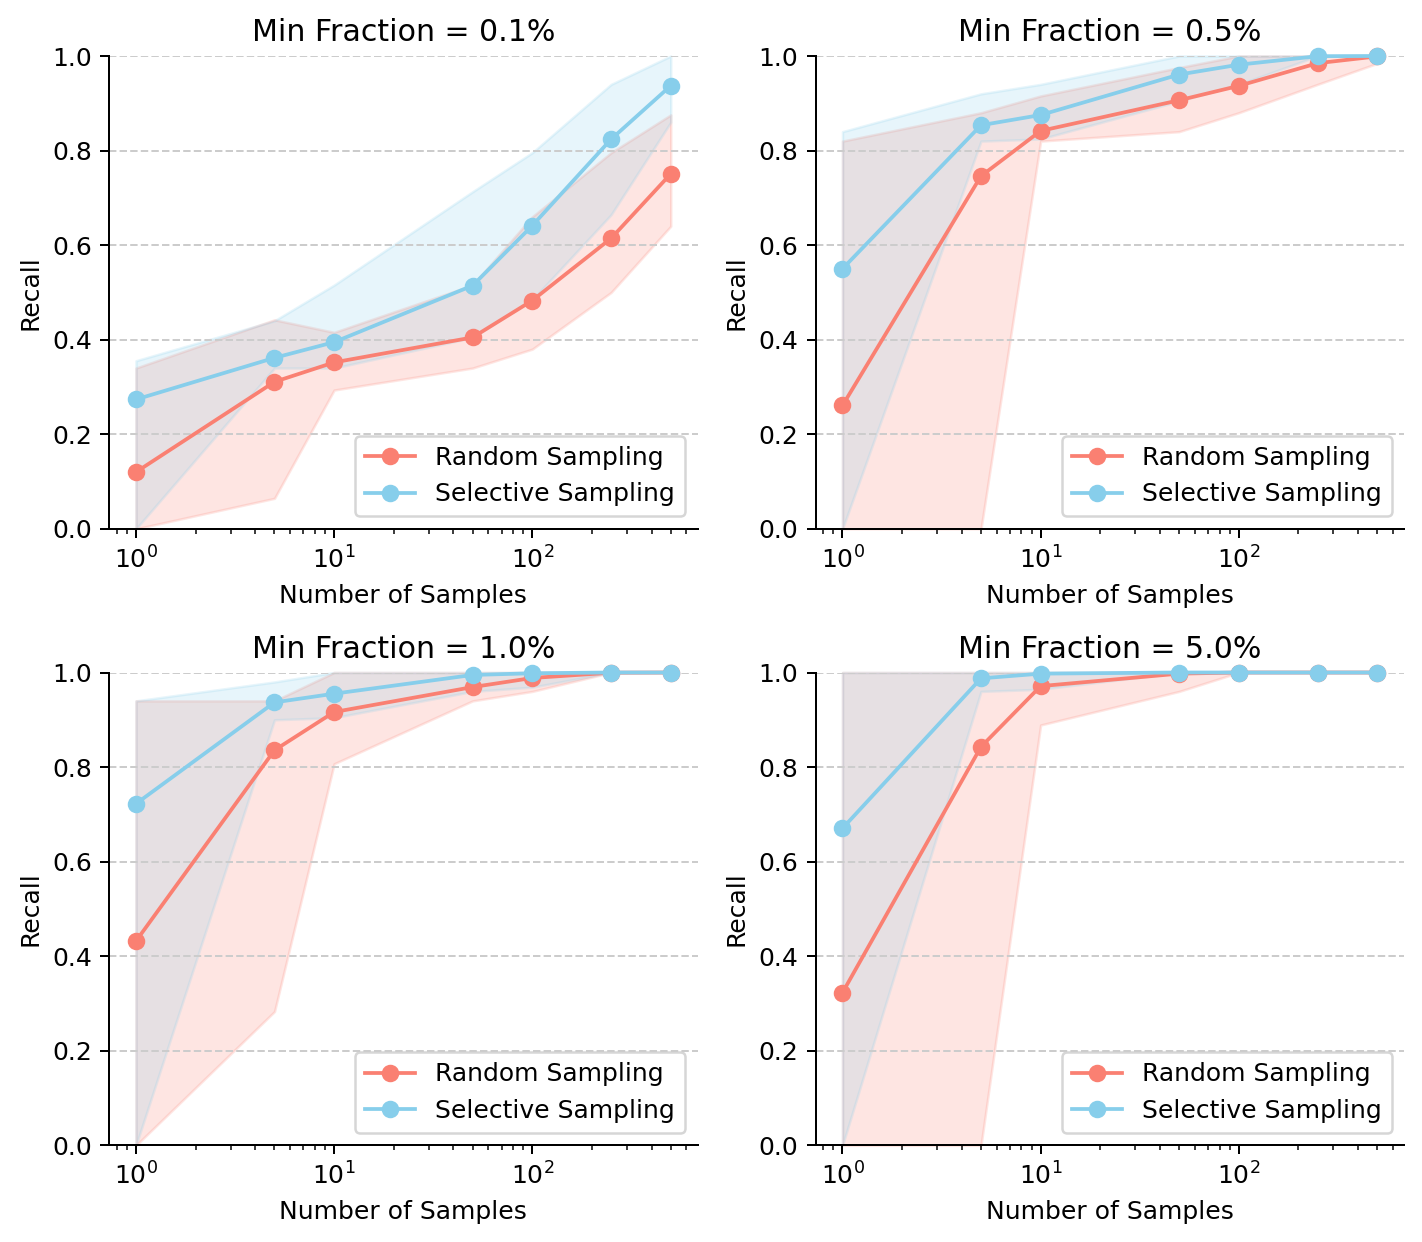

In [90]:
import matplotlib.pylab as plt

plt.figure(figsize=(8, 7), dpi=180)

for i, graph_min_items in enumerate([48, 244, 488, 2442]):
    plt.subplot(2, 2, i + 1)
    
    with open(os.path.join("example_data", f"adult_experiment_min_items_{graph_min_items}.pkl"), "rb") as file:
        (recall_random_samplings, recall_selective_samplings) = pickle.load(file)
        
    lists = sorted(recall_random_samplings.items()) # sorted by key, return a list of tuples
    lists1 = sorted(recall_selective_samplings.items()) # sorted by key, return a list of tuples

    x, y = zip(*lists) # unpack a list of pairs into two tuples
    x1, y1 = zip(*lists1)

    # y_mean = [y[i].mean() for i in range (len(y))]
    y = np.vstack(y)
    y1 = np.vstack(y1)
    y_mean = np.vstack(y).mean(axis=1)
    y1_mean = np.vstack(y1).mean(axis=1)

    y_lower = np.quantile(y, 0.025, axis=1)
    y_upper = np.quantile(y, 0.975, axis=1)

    y1_lower = np.quantile(y1, 0.025, axis=1)
    y1_upper = np.quantile(y1, 0.975, axis=1)

    plt.plot(x, y_mean, marker='o', label="Random Sampling", clip_on=False, c='salmon')
    plt.fill_between(x, y_lower, y_upper, alpha=0.2, clip_on=False, color='salmon')
    plt.plot(x1, y1_mean, marker='o', label="Selective Sampling", clip_on=False, c='skyblue')
    plt.fill_between(x1, y1_lower, y1_upper, alpha=0.2, clip_on=False, color='skyblue')
    plt.xlabel("Number of Samples")
    plt.ylabel("Recall")
    plt.semilogx()
    plt.title(f"Min Fraction = {graph_min_items / len(df) * 100:.1f}%")
    
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().grid(visible=True, axis='y', linestyle='--', c='0.8')
    plt.legend(loc='lower right')

    plt.gca().set_ylim([0, 1.0])
plt.tight_layout()
plt.show()